# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5162408.datarmor0/parcels-55081/libparcels_random_856e6087-6a9e-4fe0-ac40-90b04f3b29fe.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.110:41572 Dashboard: http://10.148.0.110:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## load Lagrangian data

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory_mean'])
#df = p['trajectory']

In [5]:
v = 'SSUV'
v = 'temperature'
#v = 'salinity'
#v = 'sea level'

In [6]:
# read raw spectra
spectra_name = 'spectra_raw'
if v!='SSUV':
    spectra_name = spectra_name+'_'+v
    
df = p.load_diagnostic(spectra_name)
#df = df.persist()
df.head()

,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,11.85,11.866666666666667,11.883333333333333,11.9,11.916666666666666,11.933333333333334,11.95,11.966666666666667,11.983333333333333,12.0
trajectory,,,,,,,,,,,,,,,,,,,,,
1000207,120,-26.770351,-75.351169,137.903870,69.322136,0.001280,0.000196,0.001208,0.000353,0.000326,...,5.996031e-08,4.706557e-08,3.223492e-08,4.436894e-08,6.057635e-08,1.644082e-09,4.761263e-08,3.025492e-08,5.703403e-08,1.149781e-10
1000207,150,-29.163544,-76.060546,139.656174,69.882080,0.000009,0.000044,0.000006,0.000006,0.000012,...,1.939989e-09,7.530394e-10,3.966165e-10,3.778581e-10,1.407654e-09,9.570944e-10,1.940154e-09,6.307867e-10,9.252107e-10,1.408482e-11
1000207,180,-32.524974,-76.693448,139.952423,69.859123,0.000092,0.000073,0.000067,0.000045,0.000032,...,7.228029e-09,1.289028e-08,1.738962e-08,1.390623e-08,1.360081e-08,9.292967e-09,5.717919e-09,1.147936e-08,7.722355e-09,1.932782e-09
1000207,210,-36.271188,-77.390706,141.131058,70.694962,0.000139,0.000049,0.000014,0.000015,0.000016,...,2.185479e-08,4.135648e-09,3.900247e-09,8.802009e-10,7.272233e-09,1.485804e-09,1.739498e-09,9.323539e-09,7.913636e-09,2.760624e-09
1000207,240,-39.300011,-77.743990,141.318054,70.638672,0.000011,0.000003,0.000005,0.000003,0.000003,...,1.353111e-10,3.874479e-10,2.696638e-09,6.601137e-11,8.830375e-10,2.131494e-10,1.364898e-09,1.423898e-09,1.730927e-09,7.772520e-10


In [7]:
# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})

df = df.map_partitions(interp_bathy)

In [8]:
# filter out depth ranges
if v=='SSUV':
    df = df[df['h']>500]

#df = df.persist()

---
## bin data: latitude

In [9]:
# bin geographically
dl = 1.
lat_bins = np.arange(-60, 60, dl)

df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['time','lon','lat', 'h'])
              .reset_index(), 
              id_vars=['lat_cut',], 
              var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 
                               'value': 'E'},
                     )
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

In [10]:
# store diagnostic
p.store_diagnostic('spectra_'+v+'_lat', ds, overwrite=True)

spectra_temperature_lat diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_temperature_lat.zarr


In [11]:
# load spectra
#ds = p.load_diagnostic('spectra_'+v+'_lat.zarr')

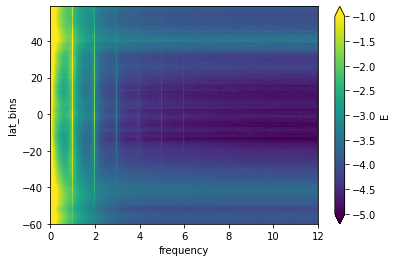

In [12]:
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

---
## bin data: longitude x latitude

Could also integrate within frequency bands first in order to ease computations

In [13]:
# bin geographically
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

df['lon'] = (df['lon']+180)%360 - 180

df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df.groupby(['lon_cut', 'lat_cut']).mean().compute()

In [14]:
#Converting pandas dataframe in xarray dataset:
index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                   E.index.map(lambda v: v[1].mid)
                                  ], 
                                  names=('lon_cut', 'lat_cut'),
                                 )
ds = (pd.melt(E.set_index(index)
              .drop(columns=['time','lon','lat', 'h'])
              .reset_index(), id_vars=['lon_cut', 'lat_cut',],
              var_name='frequency',
             )
      .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')
ds = ds.chunk({'frequency': 100})
ds

<xarray.Dataset>
Dimensions:    (frequency: 721, lat_bins: 119, lon_bins: 359)
Coordinates:
  * lon_bins   (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * frequency  (frequency) float64 0.0 0.01667 0.03333 0.05 ... 11.97 11.98 12.0
Data variables:
    E          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(359, 119, 100), meta=np.ndarray>

In [15]:
# store diagnostic
p.store_diagnostic('spectra_'+v+'_lon_lat', ds, overwrite=True)

spectra_temperature_lon_lat diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_temperature_lon_lat.zarr


In [16]:
# load spectra
#ds = p.load_diagnostic('spectra_'+v+'_lon_lat.zarr')

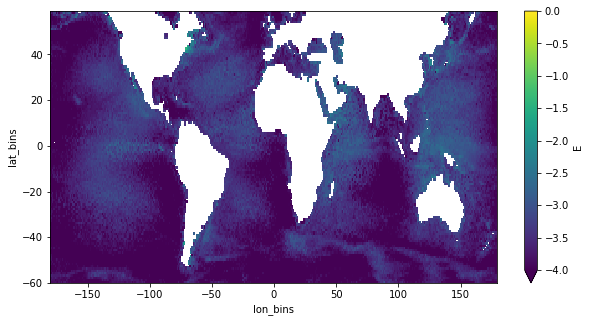

In [17]:
domega = float(ds.frequency[1]- ds.frequency[0])
bounds = (1.9, 2.1) 
_E = ds.E.where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                drop=False,
               )
E = domega * _E.sum('frequency')

np.log10(E).plot(x='lon_bins', y='lat_bins', 
                 vmin=-4, vmax=0, 
                 figsize=(10,5),
                )

### integrate in frequency bands

In [18]:
bands = {'low': (0., .5), 'diurnal': (0.9, 1.1), 'semidiurnal': (1.9, 2.1)}
#bands = {'semidiurnal': (1.9, 2.1)}

domega = float(ds.frequency[1]- ds.frequency[0])

In [19]:
Eb = {}
for b, bounds in bands.items():
    print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))
    _E = ds.E.where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                    drop=False,
                   )
    E = domega * _E.sum('frequency')    
    Eb[b] = E.persist()
    
# converts to single dataset and store:
E = xr.concat(list(Eb.values()), 
              dim=pd.Index(list(Eb.keys()),name='frequency_band'),
             )
E

Frequency band low, frequency bounds: 0.0-0.5 cpd
Frequency band diurnal, frequency bounds: 0.9-1.1 cpd
Frequency band semidiurnal, frequency bounds: 1.9-2.1 cpd


<xarray.DataArray 'E' (frequency_band: 3, lon_bins: 359, lat_bins: 119)>
dask.array<concatenate, shape=(3, 359, 119), dtype=float64, chunksize=(1, 359, 119), chunktype=numpy.ndarray>
Coordinates:
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * frequency_band  (frequency_band) object 'low' 'diurnal' 'semidiurnal'

In [20]:
# store diagnostic
p.store_diagnostic('spectra_'+v+'_lon_lat_bands', ds, overwrite=True)

spectra_temperature_lon_lat_bands diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_temperature_lon_lat_bands.zarr


---

# Eulerian spectra

!! Requires more processing power: 15 jobs


In [19]:
ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV.zarr'))
ds = ds.where(ds.Depth>500, drop=False)
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) int8 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 24, 72, 1440), meta=np.ndarray>

### lat

In [20]:
ds['lat3'] = 0*ds.face+ds.YC
ds['lat4'] = 0*ds.SSUV+ds.YC
ds = ds.persist()

In [ ]:
dl = 1.
lat_bins = np.arange(-60, 60, dl)

N = histogram(ds.lat3.rename('lat'), bins=[lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()
N.plot()

In [36]:
E = histogram(ds.lat4.rename('lat'), bins=[lat_bins], 
              weights=ds.SSUV, 
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()
E = E.rename({'freq_time': 'frequency'})

# peaks at 1.12TB of RAM ... not small

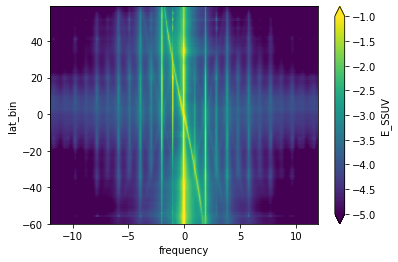

In [41]:
np.log10(E).plot(x='frequency', cmap='viridis', vmin=-5, vmax=-1)

In [42]:
# store
E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_lat.zarr'), mode='w')

In [ ]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_lat.zarr'))

### lon x lat in frequency bands

In [85]:
bands = {'low': (0., .5), 'diurnal': (0.9, 1.1), 'semidiurnal': (1.9, 2.1)}
#bands = {'semidiurnal': (1.9, 2.1)}

domega = float(ds.freq_time[1]- ds.freq_time[0])

In [74]:
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds = ds.persist()

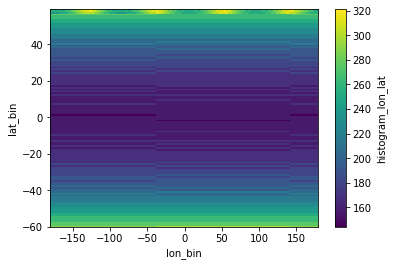

In [75]:
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
              bins=[lon_bins, lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

N.plot(x='lon_bin')

In [86]:
Eb = {}
for b, bounds in bands.items():
    print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))
    _E = ds.SSUV.where((np.abs(ds.freq_time)>=bounds[0]) & (np.abs(ds.freq_time)<=bounds[1]), 
                       drop=False,
                      )
    _E = (domega*_E.sum('freq_time'))

    E = histogram(ds.lon, ds.lat,
                  bins=[lon_bins, lat_bins], 
                  weights=_E,
                  dim=['i', 'j', 'face']
                 )

    E = (E/N).rename('E_SSUV')
    
    Eb[b] = E.persist()
    
# converts to single dataset and store:
E = xr.concat(list(Eb.values()), 
              dim=pd.Index(list(Eb.keys()),name='frequency_band'),
             )    

Frequency band low, frequency bounds: 0.0-0.5 cpd
Frequency band diurnal, frequency bounds: 0.9-1.1 cpd
Frequency band semidiurnal, frequency bounds: 1.9-2.1 cpd


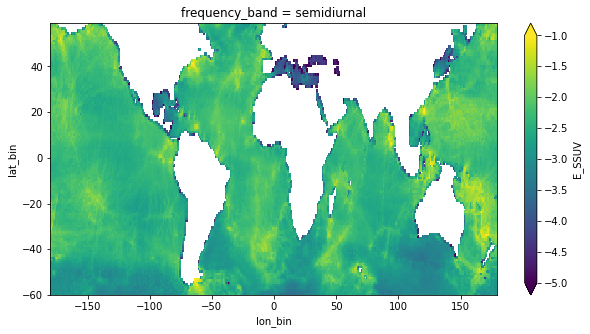

In [99]:
np.log10(E.sel(frequency_band='semidiurnal')).plot(x='lon_bin',
                                                   vmin=-5, vmax=-1, 
                                                   figsize=(10,5),
                                                  )

In [100]:
# store
E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_lon_lat.zarr'), mode='w')

In [ ]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_lon_lat.zarr'))

### code below is a bit too intensive (would require probably 20 nodes on datarmor)

Do not attempt to use it

In [51]:
ds['lon3'] = 0*ds.face+ds.XC
ds['lon4'] = 0*ds.SSUV+ds.XC
ds['lat3'] = 0*ds.face+ds.YC
ds['lat4'] = 0*ds.SSUV+ds.YC
ds = ds.persist()

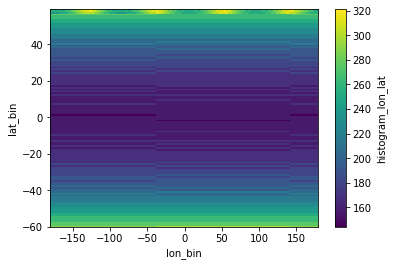

In [52]:
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

N = histogram(ds.lon3.rename('lon'), ds.lat3.rename('lat'), 
              bins=[lon_bins, lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

N.plot(x='lon_bin')

In [53]:
E = histogram(ds.lon4.rename('lon'), ds.lat4.rename('lat'),
              bins=[lon_bins, lat_bins], 
              weights=ds.SSUV,
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()
E = E.rename({'freq_time': 'frequency'})

# peaks at 20TB? of RAM ... not small

In [ ]:
np.log10(ds.E.sel(frequency=2., method='nearest')).plot(x='lon_bins', y='lat_bins', 
                                                        vmin=-4, vmax=0, 
                                                        figsize=(10,5),
                                                       )

---

# compare Eulerian and Lagrangian spectra: latitude

In [21]:
# load spectra

## lagrangian

root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

ds_L = (p.load_diagnostic('spectra_'+v+'_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

## eulerian

if v=='SSUV':
    spectra_zarr = 'SSUV_lat.zarr'
    vname = 'SSUV'
elif v=='temperature':
    spectra_zarr = 'SST_lat.zarr'
    vname = 'SST'
    
ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/'+spectra_zarr))
        .rename({'E_'+vname: 'E_Eulerian', 'lat_bin': 'lat'})
       )

# hack to make it work, should be 
#ds_E = ds_E.rename({'frequency': 'frequency_tmp'})
#ds_E = ds_E.sel(frequency_tmp=ds_L.frequency, method='nearest').drop('frequency_tmp')
#ds_E = ds_E.sel(frequency_tmp=ds_L.frequency, method='linear').drop('frequency_tmp')


# merge

ds = xr.merge([ds_L, ds_E])

In [22]:
ds_E.frequency

<xarray.DataArray 'frequency' (frequency: 721)>
array([ 0.      ,  0.016667,  0.033333, ..., 11.966667, 11.983333, 12.      ])
Coordinates:
  * frequency  (frequency) float64 0.0 0.01667 0.03333 0.05 ... 11.97 11.98 12.0

In [23]:
ds_L.frequency

<xarray.DataArray 'frequency' (frequency: 721)>
array([ 0.      ,  0.016667,  0.033333, ..., 11.966667, 11.983333, 12.      ])
Coordinates:
  * frequency  (frequency) float64 0.0 0.01667 0.03333 0.05 ... 11.97 11.98 12.0

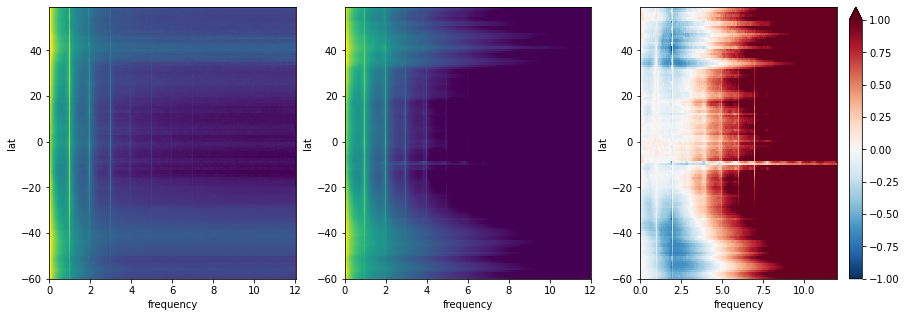

In [24]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

vmin, vmax= -5, 0

ax=axes[0]
np.log10(ds['E_Lagrangian']).plot(x='frequency', ax=ax, cmap='viridis', 
                                  vmin=vmin, vmax=vmax, add_colorbar=False,
                                 )
ax=axes[1]
np.log10(ds['E_Eulerian']).plot(x='frequency', ax=ax, cmap='viridis', 
                                vmin=vmin, vmax=vmax, add_colorbar=False,
                               )
ax=axes[2]
np.log10(ds['E_Lagrangian']/ds['E_Eulerian']).plot(x='frequency', ax=ax, 
                                                   vmin=-1, vmax=1,
                                                   cmap='RdBu_r'
                                                  )


(0.0, 2.5)

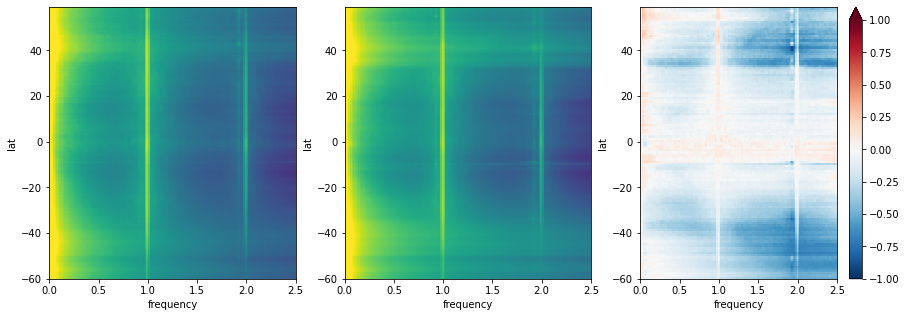

In [25]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

vmin, vmax= -5, 0
xlim = (0., 2.5)

ax=axes[0]
np.log10(ds['E_Lagrangian']).plot(x='frequency', ax=ax, cmap='viridis', 
                                  vmin=vmin, vmax=vmax, add_colorbar=False,
                                 )
ax.set_xlim(xlim)

ax=axes[1]
np.log10(ds['E_Eulerian']).plot(x='frequency', ax=ax, cmap='viridis', 
                                vmin=vmin, vmax=vmax, add_colorbar=False,
                               )
ax.set_xlim(xlim)

ax=axes[2]
np.log10(ds['E_Lagrangian']/ds['E_Eulerian']).plot(x='frequency', ax=ax, 
                                                   vmin=-1, vmax=1,
                                                   cmap='RdBu_r'
                                                  )
ax.set_xlim(xlim)

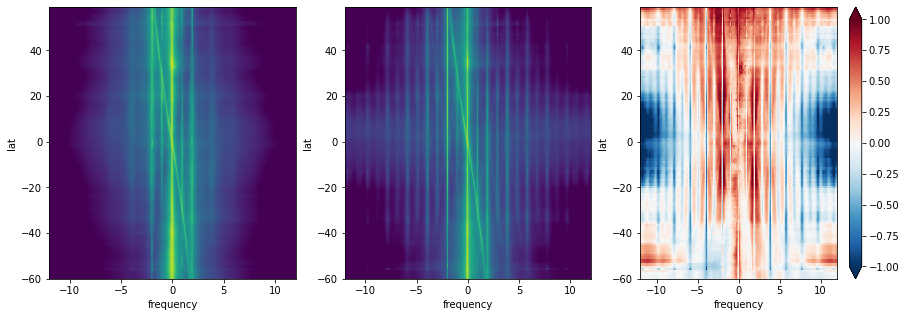

In [25]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

vmin, vmax= -5, 0

ax=axes[0]
np.log10(ds['E_Lagrangian']).plot(x='frequency', ax=ax, cmap='viridis', 
                                  vmin=vmin, vmax=vmax, add_colorbar=False,
                                 )
ax=axes[1]
np.log10(ds['E_Eulerian']).plot(x='frequency', ax=ax, cmap='viridis', 
                                vmin=vmin, vmax=vmax, add_colorbar=False,
                               )
ax=axes[2]
np.log10(ds['E_Lagrangian']/ds['E_Eulerian']).plot(x='frequency', ax=ax, 
                                                   vmin=-1, vmax=1,
                                                   cmap='RdBu_r'
                                                  )



(-4.0, 4.0)

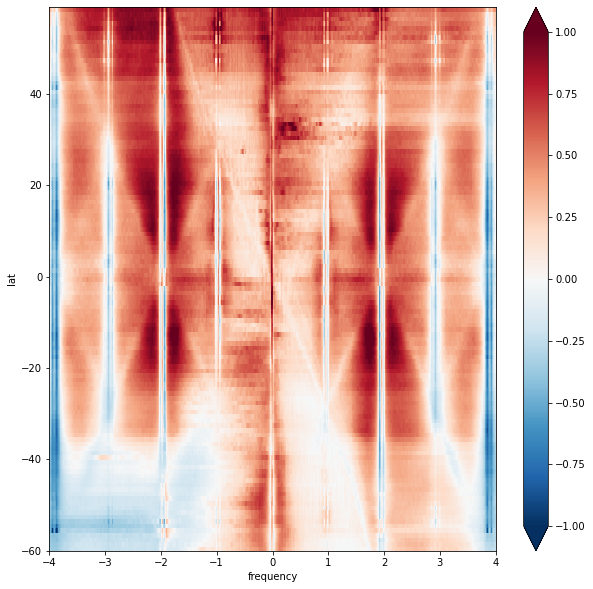

In [26]:
fig, axes = plt.subplots(1,1, figsize=(10,10))

vmin, vmax= -5, 0

ax=axes
np.log10(ds['E_Lagrangian']/ds['E_Eulerian']).plot(x='frequency', ax=ax, 
                                                   vmin=-1, vmax=1,
                                                   cmap='RdBu_r'
                                                  )
ax.set_xlim(-4,4)


## Close cluster

In [ ]:
cluster.close()